# Interactive Line Inspection — Wavelength Range Slider

This notebook demonstrates the simplest interactive pattern: using a `FloatRangeSlider` to control the wavelength bounds of a `LineInspectionPlot`. The plot updates in-place using `set_range()`, so there is no flicker or figure recreation.

**Key idea:** The `%matplotlib widget` backend keeps the figure canvas alive. We update the plot data and call `fig.canvas.draw_idle()` to refresh.

In [ ]:
# Core libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Use the interactive widget backend for matplotlib
%matplotlib widget

# IPython widget libraries
import ipywidgets as widgets
from IPython.display import display, clear_output

# iSLAT data types
from iSLAT.Modules.DataTypes import Molecule, MoleculeDict

# iSLAT standalone plot classes
from iSLAT.Modules.Plotting import (
    BasePlot,
    DEFAULT_THEME,
    LineInspectionPlot,
    PopulationDiagramPlot,
    FullSpectrumPlot,
    MainPlotGrid,
)

print("Imports successful!")
print(f"matplotlib backend: {matplotlib.get_backend()}")

Imports successful!
matplotlib backend: widget


In [ ]:
# --- Load observed data and define a molecule factory ---
import pandas as pd

from iSLAT.Modules.FileHandling import example_data_folder_path, hitran_data_folder_path

# Load CI Tau MIRI spectrum (Banzatti+2023b)
data_path = example_data_folder_path / "CITau_MIRI_Banzatti+2023b.csv"
obs = pd.read_csv(data_path)

wave_grid     = obs["wave"].values
observed_flux = obs["flux"].values
observed_err  = obs["err"].values
continuum     = obs["cont"].values

print(f"Loaded: {data_path.name}")
print(f"  {len(wave_grid)} points, {wave_grid.min():.2f}–{wave_grid.max():.2f} μm")

# Paths to HITRAN parameter files
data_dir = hitran_data_folder_path
water_par_file = str(data_dir / "data_Hitran_H2O.par")
co_par_file    = str(data_dir / "data_Hitran_CO.par")
co2_par_file   = str(data_dir / "data_Hitran_CO2.par")

# Wavelength range derived from observed data
wavelength_range = (float(wave_grid.min()), float(wave_grid.max()))

# Default molecule definitions (shared across all sections)
DEFAULT_MOLECULES = {
    "H2O": {"Molecule Name": "H2O", "temp": 850, "n_mol": 1e18, "radius": 0.5, "color": "#0000FF",
             "displaylabel": "$H_2O$", "File Path": water_par_file},
    "CO":  {"Molecule Name": "CO",  "temp": 1000, "n_mol": 1e18, "radius": 0.4, "color": "#FF0000",
             "displaylabel": "CO",  "File Path": co_par_file},
    "CO2": {"Molecule Name": "CO2", "temp": 300,  "n_mol": 1e17, "radius": 0.5, "color": "green",
             "displaylabel": "$CO_2$", "File Path": co2_par_file},
}

def create_mol_dict():
    """
    Create a fresh, independent MoleculeDict with the default molecules.

    Each call returns a new instance so that different notebook sections
    do not interfere with each other (e.g. visibility toggles, parameter
    changes, or cache state).
    """
    md = MoleculeDict(
        global_distance=160,
        global_stellar_rv=0.0,
        global_wavelength_range=wavelength_range,
        global_model_pixel_res=0.0013,
    )
    md.load_molecules(
        molecules_data=[v for v in DEFAULT_MOLECULES.values()],
        initial_molecule_parameters=DEFAULT_MOLECULES,
    )
    md.bulk_update_parameters({"fwhm": 130, "broad": 1})
    return md

# Quick sanity check
_test = create_mol_dict()
print(f"create_mol_dict() → {list(_test.keys())}")
del _test

Loaded: CITau_MIRI_Banzatti+2023b.csv
  10672 points, 4.90–28.72 μm
Deferring intensity calculations for 3 molecules
create_mol_dict() → ['H2O', 'CO', 'CO2']


Deferring intensity calculations for 3 molecules
Calculating intensity for CO: T=1000.0K, N_mol=1.00e+18, dv=1.0
Calculating intensity for H2O: T=850.0K, N_mol=1.00e+18, dv=1.0
Calculating intensity for CO2: T=300.0K, N_mol=1.00e+17, dv=1.0


FloatRangeSlider(value=(14.0, 15.0), description='λ range (μm):', layout=Layout(width='600px'), max=28.7150203…

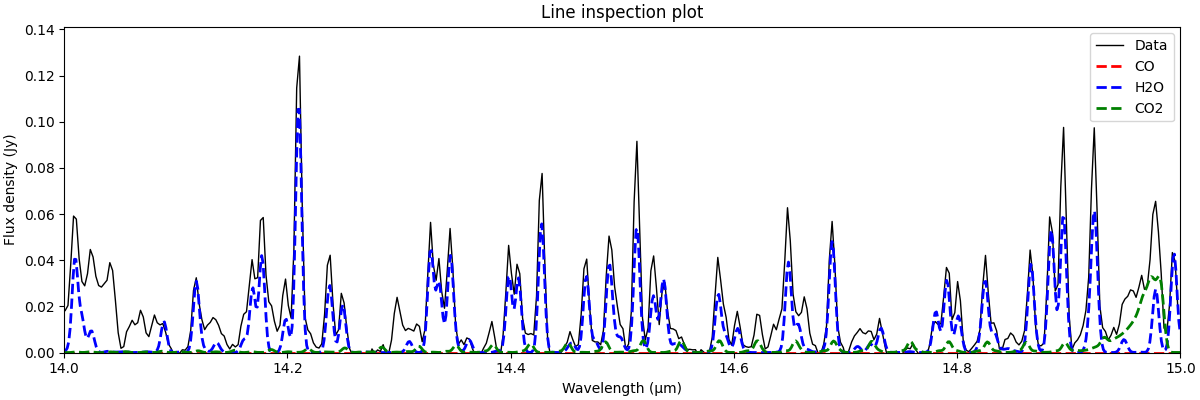

In [ ]:
# --- Interactive wavelength range slider for LineInspectionPlot ---

# Each section gets its own MoleculeDict so cells don't conflict
mol_dict_1 = create_mol_dict()

# Create the initial plot
lip = LineInspectionPlot(
    wave_data=wave_grid,
    flux_data=observed_flux,
    xmin=14.0,
    xmax=15.0,
    molecules=mol_dict_1,
    figsize=(12, 4),
)
lip.generate_plot()

# Create a range slider
wave_min, wave_max = float(wave_grid.min()), float(wave_grid.max())

range_slider = widgets.FloatRangeSlider(
    value=[14.0, 15.0],
    min=wave_min,
    max=wave_max,
    step=0.1,
    description='Wavelength range (μm):',
    continuous_update=True,         # live update as slider moves
    style={'description_width': '150px'},
    layout=widgets.Layout(width='600px'),
)

def on_range_change(change):
    """Update the plot when the slider moves."""
    xmin, xmax = change['new']
    lip.set_range(xmin, xmax)       # regenerates plot data in-place
    lip.fig.canvas.draw_idle()       # refresh the widget backend canvas

range_slider.observe(on_range_change, names='value')

# Display slider above the (already shown) figure
display(range_slider)
lip.show()